In [72]:
from __future__ import print_function
import pickle 
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

# For Elastic Transform
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates


%matplotlib inline

## Load Data

In [2]:
use_cuda = False
momentum_par = 0.5
lr = 0.01
log_interval = 10
epochs = 500

In [3]:
torch.manual_seed(42)

In [4]:
trainset_labeled = pickle.load(open("data/train_labeled.p", "rb"))

Files already downloaded
3000
750


In [5]:
validset = pickle.load(open("data/validation.p", "rb"))

In [6]:
data = trainset_labeled.train_data.numpy()
labels = trainset_labeled.train_labels.numpy()

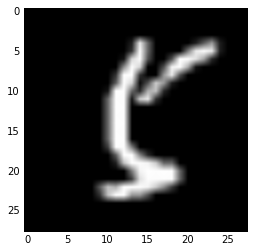

In [7]:
plt.imshow(data[1700], cmap='gray')

## Translate

In [8]:
def translate(foo,x,y,x_flip,y_flip):    
    if x_flip:
        foo=np.fliplr(foo)
    if y_flip:
        foo = np.flipud(foo)

    foo=foo[x:,y:]
    foo = np.append(foo,np.zeros((x,28-y)),axis=0)
    foo = np.append(foo,np.zeros((28,y)),axis=1)

    if x_flip:
        foo=np.fliplr(foo)
    if y_flip:
        foo = np.flipud(foo)
    return foo

In [9]:
# Takes an array of images [shape (n, 28, 28)] and an array of labels
# Returns the same
def run_translations(input_data, labels):
    output=[]
    output_labels=[]
    for (data_point, label) in zip(input_data, labels):
        for x in [0,2,4]:
            for y in [0,2,4]:
                for x_flip in [True,False]:
                    for y_flip in [True,False]:
                            if (x_flip and x==0) or (y_flip and y==0):
                                continue
                            else:
                                output.append(translate(data_point, x, y, x_flip, y_flip))
                                output_labels.append(label)
    output = np.array(output)
    return output, output_labels

## Rotation

In [10]:
from scipy.ndimage.interpolation import rotate

In [38]:
# Takes an array of images [shape (n, 28, 28)] and an array of labels
# Returns the same
def run_rotations(input_data, labels, angles):
    output=[]
    output_labels=[]
    for (data_point, label) in zip(input_data, labels):
        output.append(data_point)
        output_labels.append(label)
        for angle in angles:
            output.append(rotate(data_point, angle, reshape=False))
            output_labels.append(label)
    output = np.array(output)
    return output, output_labels

## Warping

In [12]:
#https://gist.github.com/chsasank/4d8f68caf01f041a6453e67fb30f8f5a

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape)==2

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=1).reshape(shape)

In [74]:
# Takes an array of images [shape (n, 28, 28)] and an array of labels
# Returns the same
def run_elastic_transforms(input_data, labels, alpha,sigma):
    output=[]
    output_labels=[]
    count=0
    for (data_point, label) in zip(input_data, labels):
        if count % 1000 == 0:
            print(count)

        output.append(data_point)
        output_labels.append(label)
        
        output.append(elastic_transform(data_point, alpha, sigma))
        output_labels.append(label)
        count+=1
    output = np.array(output)
    return output, output_labels

## Running Transformations

In [39]:
angles = (-45, 45)
rot_data,rot_labels = run_rotations(data, labels, angles)

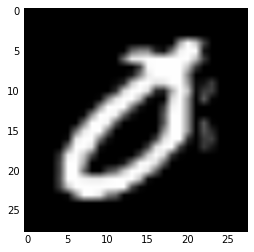

In [47]:
plt.imshow(rot_data[180], cmap='gray')

In [48]:
trans_rot_data, trans_rot_labels = run_translations(rot_data,rot_labels)

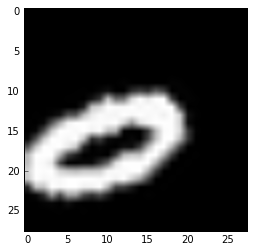

In [65]:
plt.imshow(trans_rot_data[188], cmap='gray')

In [66]:
ALPHA = 36
SIGMA = 5.5

In [75]:
aug_data, aug_labels = run_elastic_transforms(trans_rot_data, trans_rot_labels, ALPHA,SIGMA)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [76]:
with open('data/aug_data.p', 'wb') as fp:
    pickle.dump(aug_data, fp)
with open('data/aug_labels.p', 'wb') as fp:
    pickle.dump(aug_labels, fp)

In [81]:
aug_data = aug_data.reshape(450000,1,28,28)

In [82]:
aug_labels=np.array(aug_labels)

In [83]:
idx = np.random.choice(np.arange(len(aug_labels)), 50000, replace=False)
aug_data_sample50k = aug_data[idx]
aug_labels_sample50k = aug_labels[idx]

In [85]:
with open('data/aug_data_sample50k.p', 'wb') as fp:
    pickle.dump(aug_data_sample50k, fp)
with open('data/aug_labels_sample50k.p', 'wb') as fp:
    pickle.dump(aug_labels_sample50k, fp)

In [92]:
aug_labels_sample50k[8769]

4

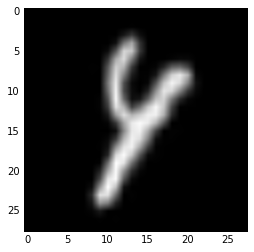

In [93]:
plt.imshow(aug_data_sample50k[8769][0], cmap='gray')

## ZCA

In [ ]:
def zca_whitening(train_data, epsilon=1, valid_data=None):
    #Epsilon is whitening constant, and prevents division by zero
    
    data = train_data.numpy()
    orig_shape = data.shape
    data = data.reshape(data.shape[0],data.shape[1]*data.shape[2])
    
    # Correlation matrix requires zero-mean
    mu = np.mean(data, axis=0)
    data=(data-mu).T

    sigma = np.dot(data, data.T)/data.shape[1] #Correlation matrix
    U,S,_ = np.linalg.svd(sigma) #Singular Value Decomposition
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(S + epsilon))), U.T)  #ZCA Whitening matrix
    
    whitened_train_data = np.dot(ZCAMatrix, data).T.reshape(orig_shape)
    
    if type(valid_data)==type(None):
        whitened_valid_data=None
    else:
        valid_data=valid_data.numpy()
        orig_valid_shape = valid_data.shape
        valid_data = valid_data.reshape(valid_data.shape[0],valid_data.shape[1]*valid_data.shape[2])
        valid_data=(valid_data-mu).T
        whitened_valid_data = np.dot(ZCAMatrix, valid_data).T.reshape(orig_valid_shape)
    
    return ZCAMatrix, whitened_train_data, whitened_valid_data

In [ ]:
_, white_train_data, white_valid_data = zca_whitening(trainset_labeled.train_data, epsilon=1e-1, valid_data=validset.test_data)

In [ ]:
white_train_data = torch.from_numpy(white_train_data).float()

In [ ]:
white_trainset_labeled = torch.utils.data.TensorDataset(white_train_data, trainset_labeled.train_labels)

In [ ]:
tempset = trainset_labeled

In [ ]:
type(trainset_labeled.train_data), trainset_labeled.train_data.size()

In [ ]:
type(tempset.train_data), tempset.train_data.size()

In [ ]:
tempset.train_data=white_train_data

In [ ]:
white_trainset_labeled.target_tensor.size()

In [ ]:
imshow(white_valid_data[0])

In [ ]:
imshow(trainset_labeled[0][0])

In [ ]:
for i in range(-5,5):
    _, data_whitened = zca_whitening(data, epsilon=10**i)
    data_whitened = data_whitened.reshape(orig_shape)
    print(i)
    plt.imshow(data_whitened[0], cmap='gray')
    plt.show()

In [ ]:
data = trainset_labeled[:,0,:,:,:].numpy()
labels = trainset_labeled[:,1,:,:].numpy()
data = data.reshape(data.shape[0], 28 * 28)

In [ ]:
imshow(trainset_labeled[800][0])

In [ ]:
print("Images")
imshow(torchvision.utils.make_grid(incorrect_pixels))

In [ ]:
print("Actual labels:", incorrect_outputs)